#### Data Loading

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Paths
DATA_PATH = r"C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\data\nutrition_queries_dataset.csv"
OUTPUT_DIR = r"C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\data\train_test"
FULL_DATA_OUT = r"C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\data\nutrition_queries_clean.csv"
TRAIN_OUT = os.path.join(OUTPUT_DIR, "train.csv")
TEST_OUT  = os.path.join(OUTPUT_DIR, "test.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)


#### 1. Load Dataset

In [2]:
df = pd.read_csv(DATA_PATH)
print("Initial shape:", df.shape)
print(df.head())


Initial shape: (4100, 9)
   id                                              query           label  \
0   1  Compare the vitamin C content in fresh vs froz...      comparison   
1   2  Which has lower phytate: unfermented ogi or so...      comparison   
2   3  How much zinc should a 3-year-old child with c...  recommendation   
3   4  What foods should I eat if I have CKD stage 3 ...         therapy   
4   5    Explain how vitamin K helps with blood clotting         general   

   complexity recommended_llm  needs_followup distractor_label  \
0           2       TinyLlama            True              NaN   
1           4         Mistral            True              NaN   
2           5         Mistral            True              NaN   
3           5         Mistral           False              NaN   
4           4         Mistral           False              NaN   

       biomarkers  is_high_risk  
0   ["vitamin_c"]         False  
1     ["phytate"]         False  
2        ["zinc"]  

##### 2. Drop Unnecessary Columns (id only)

In [3]:
df_full = df.drop(columns=["id"])
print("After dropping 'id':", df_full.shape)


After dropping 'id': (4100, 8)


In [4]:
# Missing values
print("\nMissing values per column:")
print(df_full.isnull().sum())



Missing values per column:
query                  0
label                  0
complexity             0
recommended_llm        0
needs_followup         0
distractor_label    3400
biomarkers             0
is_high_risk           0
dtype: int64


In [5]:
# Label distribution
print("\nLabel distribution:")
print(df_full["label"].value_counts())


Label distribution:
label
recommendation    1232
therapy           1031
comparison         989
general            848
Name: count, dtype: int64


### Exploratory Data Analysis

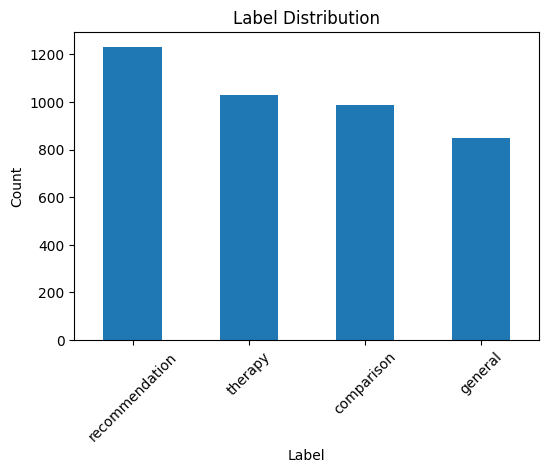

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
df_full["label"].value_counts().plot(kind="bar")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [8]:
# Query length distribution
df_full["query_length"] = df_full["query"].apply(lambda x: len(str(x).split()))
print("\nQuery length stats:")
print(df_full["query_length"].describe())


Query length stats:
count    4100.000000
mean       10.792439
std         2.025235
min         6.000000
25%         9.000000
50%        11.000000
75%        12.000000
max        18.000000
Name: query_length, dtype: float64


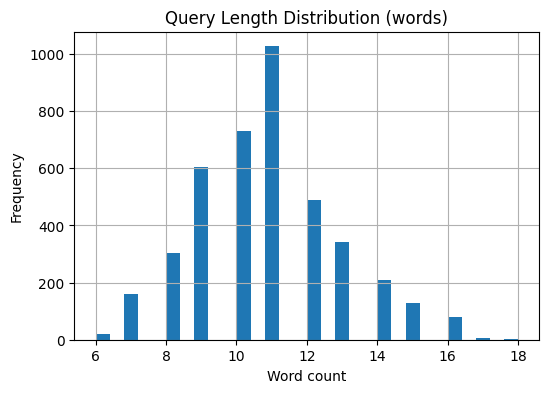

In [9]:
plt.figure(figsize=(6,4))
df_full["query_length"].hist(bins=30)
plt.title("Query Length Distribution (words)")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()


#### 3. Save Full Cleaned Dataset (for RAG logic)

In [10]:
df_full.to_csv(FULL_DATA_OUT, index=False)
print(f"✅ Full cleaned dataset saved at: {FULL_DATA_OUT}")

✅ Full cleaned dataset saved at: C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\data\nutrition_queries_clean.csv


#### 4. Extract Training Subset (query + label only)

In [11]:
df_train_ready = df_full[["query", "label"]]

#### 5. Train-Test Split

In [12]:
train_df, test_df = train_test_split(
    df_train_ready,
    test_size=0.2,
    random_state=42,
    stratify=df_train_ready["label"]
)

In [13]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (3280, 2)
Test shape: (820, 2)


#### Save Train/Test Files

In [14]:
train_df.to_csv(TRAIN_OUT, index=False)
test_df.to_csv(TEST_OUT, index=False)

In [15]:
print(f"✅ Train set saved at: {TRAIN_OUT}")
print(f"✅ Test set saved at: {TEST_OUT}")

✅ Train set saved at: C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\data\train_test\train.csv
✅ Test set saved at: C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\data\train_test\test.csv


#### Tokenization & Model Training

In [17]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import pandas as pd
import os

# ================================
# 1. Paths
# ================================
MODEL_PATH = r"C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\models\distilbert-base-uncased"
DATA_DIR = r"C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\data\train_test"

# ================================
# 2. Load train/test
# ================================
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

print("Train size:", len(train_df))
print("Test size:", len(test_df))
print(train_df.head())


c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train size: 3280
Test size: 820
                                               query           label
0  How can clinical dietitians use phytate compos...         general
1  What protein intake is ideal for a 55kg South ...  recommendation
2  Suggest foods from the Food Composition Table ...  recommendation
3  Compare the effects of calcium carbonate and a...      comparison
4  How should a patient with kidney stones adjust...         therapy


In [18]:
# ================================
# 3. Encode Labels
# ================================
unique_labels = sorted(train_df["label"].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

train_df["label"] = train_df["label"].map(label2id)
test_df["label"] = test_df["label"].map(label2id)

# ================================
# 4. Convert to Dataset
# ================================
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# ================================
# 5. Tokenizer
# ================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

def tokenize(batch):
    return tokenizer(batch["query"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# ================================
# 6. Model
# ================================
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)


c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 820/820 [00:00<00:00, 7718.49 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\models\distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%pip install evaluate


In [19]:
# 7. Training Arguments
# ================================
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# ================================
# 8. Metrics
# ================================
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=p.label_ids)["accuracy"],
        "f1": f1.compute(predictions=preds, references=p.label_ids, average="weighted")["f1"]
    }

# ================================
# 9. Trainer
# ================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:

# 10. Train
# ================================
trainer.train()
# ================================
# 11. Save Final Model
# ================================
SAVE_DIR = r"C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\models\distilbert-classifier-v1"

trainer.save_model(SAVE_DIR)       # saves model + config
tokenizer.save_pretrained(SAVE_DIR)

print(f"✅ Model and tokenizer saved to {SAVE_DIR}")

  0%|          | 0/615 [00:00<?, ?it/s]c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  2%|▏         | 10/615 [01:00<51:00,  5.06s/it] 

{'loss': 1.3487, 'grad_norm': 1.8225659132003784, 'learning_rate': 1.9674796747967483e-05, 'epoch': 0.05}


  3%|▎         | 20/615 [01:52<55:02,  5.55s/it]

{'loss': 1.2125, 'grad_norm': 3.416842222213745, 'learning_rate': 1.934959349593496e-05, 'epoch': 0.1}


  5%|▍         | 30/615 [02:49<53:11,  5.46s/it]

{'loss': 1.0412, 'grad_norm': 3.315221071243286, 'learning_rate': 1.902439024390244e-05, 'epoch': 0.15}


  7%|▋         | 40/615 [03:40<48:08,  5.02s/it]

{'loss': 0.7859, 'grad_norm': 3.2194604873657227, 'learning_rate': 1.869918699186992e-05, 'epoch': 0.2}


  8%|▊         | 50/615 [04:33<47:07,  5.01s/it]

{'loss': 0.5541, 'grad_norm': 3.423278331756592, 'learning_rate': 1.83739837398374e-05, 'epoch': 0.24}


 10%|▉         | 60/615 [05:25<48:30,  5.24s/it]

{'loss': 0.3748, 'grad_norm': 5.758716583251953, 'learning_rate': 1.804878048780488e-05, 'epoch': 0.29}


 11%|█▏        | 70/615 [06:16<45:41,  5.03s/it]

{'loss': 0.2323, 'grad_norm': 2.2051889896392822, 'learning_rate': 1.772357723577236e-05, 'epoch': 0.34}


 13%|█▎        | 80/615 [07:09<47:01,  5.27s/it]

{'loss': 0.1484, 'grad_norm': 0.8041062355041504, 'learning_rate': 1.739837398373984e-05, 'epoch': 0.39}


 15%|█▍        | 90/615 [07:58<41:14,  4.71s/it]

{'loss': 0.1405, 'grad_norm': 0.5700523853302002, 'learning_rate': 1.7073170731707317e-05, 'epoch': 0.44}


 16%|█▋        | 100/615 [08:50<43:37,  5.08s/it]

{'loss': 0.0987, 'grad_norm': 1.9004207849502563, 'learning_rate': 1.6747967479674798e-05, 'epoch': 0.49}


 18%|█▊        | 110/615 [10:45<2:35:20, 18.46s/it]

{'loss': 0.0708, 'grad_norm': 0.39672955870628357, 'learning_rate': 1.642276422764228e-05, 'epoch': 0.54}


 20%|█▉        | 120/615 [12:18<1:19:38,  9.65s/it]

{'loss': 0.0747, 'grad_norm': 0.674391508102417, 'learning_rate': 1.6097560975609757e-05, 'epoch': 0.59}


 21%|██        | 130/615 [13:28<1:00:27,  7.48s/it]

{'loss': 0.0569, 'grad_norm': 4.362966060638428, 'learning_rate': 1.5772357723577235e-05, 'epoch': 0.63}


 23%|██▎       | 140/615 [14:30<44:09,  5.58s/it]  

{'loss': 0.041, 'grad_norm': 0.26869073510169983, 'learning_rate': 1.5447154471544717e-05, 'epoch': 0.68}


 24%|██▍       | 150/615 [15:29<47:59,  6.19s/it]

{'loss': 0.048, 'grad_norm': 2.698367118835449, 'learning_rate': 1.5121951219512196e-05, 'epoch': 0.73}


 26%|██▌       | 160/615 [16:25<44:07,  5.82s/it]

{'loss': 0.0307, 'grad_norm': 0.23180370032787323, 'learning_rate': 1.4796747967479676e-05, 'epoch': 0.78}


 28%|██▊       | 170/615 [17:19<37:49,  5.10s/it]

{'loss': 0.0756, 'grad_norm': 4.427389621734619, 'learning_rate': 1.4471544715447157e-05, 'epoch': 0.83}


 29%|██▉       | 180/615 [18:10<38:14,  5.27s/it]

{'loss': 0.0415, 'grad_norm': 8.300189971923828, 'learning_rate': 1.4146341463414635e-05, 'epoch': 0.88}


 31%|███       | 190/615 [19:39<1:14:34, 10.53s/it]

{'loss': 0.1028, 'grad_norm': 8.463193893432617, 'learning_rate': 1.3821138211382115e-05, 'epoch': 0.93}


 33%|███▎      | 200/615 [20:54<55:29,  8.02s/it]  

{'loss': 0.0667, 'grad_norm': 0.12615372240543365, 'learning_rate': 1.3495934959349594e-05, 'epoch': 0.98}


                                                 
 33%|███▎      | 205/615 [23:10<47:09,  6.90s/it]

{'eval_loss': 0.030097730457782745, 'eval_accuracy': 0.9939024390243902, 'eval_f1': 0.9938999886878395, 'eval_runtime': 100.7952, 'eval_samples_per_second': 8.135, 'eval_steps_per_second': 0.516, 'epoch': 1.0}


c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 34%|███▍      | 210/615 [24:12<2:01:03, 17.94s/it]

{'loss': 0.0798, 'grad_norm': 2.8848116397857666, 'learning_rate': 1.3170731707317076e-05, 'epoch': 1.02}


 36%|███▌      | 220/615 [25:33<50:08,  7.62s/it]  

{'loss': 0.0261, 'grad_norm': 3.706219434738159, 'learning_rate': 1.2845528455284555e-05, 'epoch': 1.07}


 37%|███▋      | 230/615 [26:34<39:25,  6.14s/it]

{'loss': 0.0132, 'grad_norm': 0.256814569234848, 'learning_rate': 1.2520325203252033e-05, 'epoch': 1.12}


 39%|███▉      | 240/615 [27:36<35:12,  5.63s/it]

{'loss': 0.0385, 'grad_norm': 0.10007163137197495, 'learning_rate': 1.2195121951219513e-05, 'epoch': 1.17}


 41%|████      | 250/615 [28:31<35:13,  5.79s/it]

{'loss': 0.0382, 'grad_norm': 0.13221238553524017, 'learning_rate': 1.1869918699186992e-05, 'epoch': 1.22}


 42%|████▏     | 260/615 [29:25<30:55,  5.23s/it]

{'loss': 0.0334, 'grad_norm': 8.592293739318848, 'learning_rate': 1.1544715447154474e-05, 'epoch': 1.27}


 44%|████▍     | 270/615 [30:14<29:04,  5.06s/it]

{'loss': 0.0093, 'grad_norm': 0.14628095924854279, 'learning_rate': 1.1219512195121953e-05, 'epoch': 1.32}


 46%|████▌     | 280/615 [31:12<31:43,  5.68s/it]

{'loss': 0.0086, 'grad_norm': 0.15606772899627686, 'learning_rate': 1.0894308943089431e-05, 'epoch': 1.37}


 47%|████▋     | 290/615 [32:11<32:26,  5.99s/it]

{'loss': 0.025, 'grad_norm': 0.12069474160671234, 'learning_rate': 1.0569105691056911e-05, 'epoch': 1.41}


 49%|████▉     | 300/615 [33:02<26:04,  4.97s/it]

{'loss': 0.0104, 'grad_norm': 0.07139445096254349, 'learning_rate': 1.024390243902439e-05, 'epoch': 1.46}


 50%|█████     | 310/615 [33:51<24:19,  4.79s/it]

{'loss': 0.0072, 'grad_norm': 0.05818052962422371, 'learning_rate': 9.91869918699187e-06, 'epoch': 1.51}


 52%|█████▏    | 320/615 [34:41<26:25,  5.38s/it]

{'loss': 0.0158, 'grad_norm': 0.06166370213031769, 'learning_rate': 9.59349593495935e-06, 'epoch': 1.56}


 54%|█████▎    | 330/615 [35:30<22:28,  4.73s/it]

{'loss': 0.0065, 'grad_norm': 0.06753739714622498, 'learning_rate': 9.268292682926831e-06, 'epoch': 1.61}


 55%|█████▌    | 340/615 [36:20<25:05,  5.48s/it]

{'loss': 0.0517, 'grad_norm': 0.0951601192355156, 'learning_rate': 8.94308943089431e-06, 'epoch': 1.66}


 57%|█████▋    | 350/615 [37:11<22:22,  5.07s/it]

{'loss': 0.0059, 'grad_norm': 0.07053299993276596, 'learning_rate': 8.617886178861789e-06, 'epoch': 1.71}


 59%|█████▊    | 360/615 [38:01<22:40,  5.34s/it]

{'loss': 0.0064, 'grad_norm': 0.056401077657938004, 'learning_rate': 8.292682926829268e-06, 'epoch': 1.76}


 60%|██████    | 370/615 [38:48<19:35,  4.80s/it]

{'loss': 0.0057, 'grad_norm': 0.1311776489019394, 'learning_rate': 7.967479674796748e-06, 'epoch': 1.8}


 62%|██████▏   | 380/615 [39:38<18:59,  4.85s/it]

{'loss': 0.0055, 'grad_norm': 0.11856084316968918, 'learning_rate': 7.64227642276423e-06, 'epoch': 1.85}


 63%|██████▎   | 390/615 [40:25<17:40,  4.72s/it]

{'loss': 0.0062, 'grad_norm': 0.8391358852386475, 'learning_rate': 7.317073170731707e-06, 'epoch': 1.9}


 65%|██████▌   | 400/615 [41:15<17:42,  4.94s/it]

{'loss': 0.0282, 'grad_norm': 0.06625353544950485, 'learning_rate': 6.991869918699188e-06, 'epoch': 1.95}


 67%|██████▋   | 410/615 [42:15<18:24,  5.39s/it]

{'loss': 0.0055, 'grad_norm': 0.049556195735931396, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


                                                 
 67%|██████▋   | 410/615 [43:23<18:24,  5.39s/it]

{'eval_loss': 0.00890576746314764, 'eval_accuracy': 0.9975609756097561, 'eval_f1': 0.9975612101509927, 'eval_runtime': 68.53, 'eval_samples_per_second': 11.966, 'eval_steps_per_second': 0.759, 'epoch': 2.0}


c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 68%|██████▊   | 420/615 [44:17<19:11,  5.90s/it]  

{'loss': 0.0148, 'grad_norm': 0.07391249388456345, 'learning_rate': 6.341463414634147e-06, 'epoch': 2.05}


 70%|██████▉   | 430/615 [45:02<14:06,  4.58s/it]

{'loss': 0.005, 'grad_norm': 0.0528334379196167, 'learning_rate': 6.016260162601627e-06, 'epoch': 2.1}


 72%|███████▏  | 440/615 [45:52<14:08,  4.85s/it]

{'loss': 0.0047, 'grad_norm': 0.04471154138445854, 'learning_rate': 5.691056910569106e-06, 'epoch': 2.15}


 73%|███████▎  | 450/615 [46:40<12:31,  4.55s/it]

{'loss': 0.0095, 'grad_norm': 0.051254525780677795, 'learning_rate': 5.365853658536586e-06, 'epoch': 2.2}


 75%|███████▍  | 460/615 [47:33<13:39,  5.29s/it]

{'loss': 0.006, 'grad_norm': 0.04381261393427849, 'learning_rate': 5.040650406504065e-06, 'epoch': 2.24}


 76%|███████▋  | 470/615 [48:22<11:35,  4.80s/it]

{'loss': 0.0041, 'grad_norm': 0.045422475785017014, 'learning_rate': 4.715447154471545e-06, 'epoch': 2.29}


 78%|███████▊  | 480/615 [49:11<10:55,  4.86s/it]

{'loss': 0.0043, 'grad_norm': 0.044410113245248795, 'learning_rate': 4.390243902439025e-06, 'epoch': 2.34}


 80%|███████▉  | 490/615 [49:57<09:28,  4.54s/it]

{'loss': 0.004, 'grad_norm': 0.04373467341065407, 'learning_rate': 4.0650406504065046e-06, 'epoch': 2.39}


 81%|████████▏ | 500/615 [50:48<09:03,  4.73s/it]

{'loss': 0.0095, 'grad_norm': 5.790186882019043, 'learning_rate': 3.7398373983739838e-06, 'epoch': 2.44}


 83%|████████▎ | 510/615 [51:38<09:12,  5.27s/it]

{'loss': 0.0041, 'grad_norm': 0.04808785393834114, 'learning_rate': 3.414634146341464e-06, 'epoch': 2.49}


 85%|████████▍ | 520/615 [52:29<08:22,  5.29s/it]

{'loss': 0.0039, 'grad_norm': 0.05654521659016609, 'learning_rate': 3.0894308943089435e-06, 'epoch': 2.54}


 86%|████████▌ | 530/615 [53:21<07:15,  5.13s/it]

{'loss': 0.0137, 'grad_norm': 5.164434432983398, 'learning_rate': 2.764227642276423e-06, 'epoch': 2.59}


 88%|████████▊ | 540/615 [54:13<06:28,  5.18s/it]

{'loss': 0.0036, 'grad_norm': 0.0381176695227623, 'learning_rate': 2.4390243902439027e-06, 'epoch': 2.63}


 89%|████████▉ | 550/615 [55:02<05:16,  4.87s/it]

{'loss': 0.0037, 'grad_norm': 0.03954417258501053, 'learning_rate': 2.1138211382113824e-06, 'epoch': 2.68}


 91%|█████████ | 560/615 [55:53<04:40,  5.11s/it]

{'loss': 0.004, 'grad_norm': 0.04365215450525284, 'learning_rate': 1.788617886178862e-06, 'epoch': 2.73}


 93%|█████████▎| 570/615 [56:46<03:52,  5.17s/it]

{'loss': 0.0038, 'grad_norm': 0.040008097887039185, 'learning_rate': 1.4634146341463414e-06, 'epoch': 2.78}


 94%|█████████▍| 580/615 [57:37<02:53,  4.94s/it]

{'loss': 0.0035, 'grad_norm': 0.03714326396584511, 'learning_rate': 1.1382113821138213e-06, 'epoch': 2.83}


 96%|█████████▌| 590/615 [58:29<02:05,  5.01s/it]

{'loss': 0.0063, 'grad_norm': 0.038279786705970764, 'learning_rate': 8.130081300813009e-07, 'epoch': 2.88}


 98%|█████████▊| 600/615 [59:18<01:12,  4.81s/it]

{'loss': 0.0079, 'grad_norm': 0.06631714105606079, 'learning_rate': 4.878048780487805e-07, 'epoch': 2.93}


 99%|█████████▉| 610/615 [1:00:09<00:24,  4.88s/it]

{'loss': 0.0038, 'grad_norm': 0.03889930248260498, 'learning_rate': 1.6260162601626018e-07, 'epoch': 2.98}


100%|██████████| 615/615 [1:00:35<00:00,  4.99s/it]c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                                                   
100%|██████████| 615/615 [1:01:47<00:00,  4.99s/it]

{'eval_loss': 0.0046887509524822235, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_runtime': 70.9264, 'eval_samples_per_second': 11.561, 'eval_steps_per_second': 0.733, 'epoch': 3.0}


100%|██████████| 615/615 [1:01:48<00:00,  6.03s/it]


{'train_runtime': 3708.9044, 'train_samples_per_second': 2.653, 'train_steps_per_second': 0.166, 'train_loss': 0.11536047829360496, 'epoch': 3.0}
✅ Model and tokenizer saved to C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\models\distilbert-classifier-v1


#### Loading Model

In [23]:
# ================================
# 1. Imports
# ================================
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Path to your saved model
model_path = r"C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\models\distilbert-classifier-v1"

# ================================
# 2. Load Model & Tokenizer
# ================================
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# ================================
# 3. Create Pipeline
# ================================
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# ================================
# 4. Helper Function
# ================================
def predict_query(query: str):
    result = classifier(query)[0]  # only take the first prediction
    label = result["label"]
    score = round(result["score"], 4)
    return {"query": query, "label": label, "confidence": score}

# ================================
# 5. Example Usage
# ================================
queries = [
    "Compare the vitamin C in mango and guava.",
    "I need a diet plan for type 2 diabetes.",
    "What is the nutrient composition of sorghum?",
    "Can a kidney patient eat high protein foods?"
]

for q in queries:
    print(predict_query(q))

{'query': 'Compare the vitamin C in mango and guava.', 'label': 'comparison', 'confidence': 0.9977}
{'query': 'I need a diet plan for type 2 diabetes.', 'label': 'therapy', 'confidence': 0.996}
{'query': 'What is the nutrient composition of sorghum?', 'label': 'general', 'confidence': 0.9974}
{'query': 'Can a kidney patient eat high protein foods?', 'label': 'therapy', 'confidence': 0.9051}
